In [1]:
import psycopg2
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

/usr/local/lib/python3.7/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [8]:
conn = psycopg2.connect("dbname=football")
cur = conn.cursor()

sql = """
WITH markets AS (
    SELECT
        event_name,
        event_id,
        open_date,
        mc_id
    FROM
        market_changes
    GROUP BY
        event_name,
        event_id,
        open_date,
        mc_id
)

SELECT
mc.event_name,
mc.event_id,
mc.open_date,
min(r.name) AS score_name
FROM
runners r
INNER JOIN
markets mc
ON mc.mc_id = r.mc_id
WHERE r.status = 'WINNER'
GROUP BY
mc.event_name,
mc.event_id,
mc.open_date
ORDER BY
mc.event_id
"""

cur.execute(sql)

results = cur.fetchall()
colnames = [desc[0] for desc in cur.description]
conn.close()

In [9]:
df = pd.DataFrame(results, columns=colnames)
df.head()

,event_name,event_id,open_date,score_name
0,T v A,27041861,2013-07-29 10:14:25,0 - 0
1,New v Cat 5,27041907,2013-07-29 11:44:42,1 - 0
2,Test v Subject,27144881,2015-12-14 12:34:00,1 - 0
3,Test v Subject,27144881,2020-02-06 11:30:00,1 - 0
4,Tottenham v Man City,27425811,2015-05-03 15:00:00,0 - 1


In [10]:
df.shape

(25036, 4)

### Creating results

In [14]:
df.loc[:, 'home_team'] = df.event_name.apply(lambda x: x.split(' v ')[0])
df.loc[:, 'away_team'] = df.event_name.apply(lambda x: x.split(' v ')[-1])
df = df[(df.open_date >= '2015-04-01') & (df.open_date < '2019-01-01')].sort_values(by='open_date')
df.head()

/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,event_name,event_id,open_date,score_name,home_team,away_team
6,Leicester v Chelsea,27425814,2015-04-29 18:45:00,1 - 3,Leicester,Chelsea
93,Nostell Miners Welfare v Frickley Athletic,27434210,2015-05-01 18:30:00,Any Other Away Win,Nostell Miners Welfare,Frickley Athletic
17,Celtic v Dundee,27428357,2015-05-01 18:45:00,5 - 0,Celtic,Dundee
59,Nottm Forest v Cardiff,27428775,2015-05-02 11:15:00,1 - 2,Nottm Forest,Cardiff
58,Norwich v Fulham,27428774,2015-05-02 11:15:00,4 - 2,Norwich,Fulham


## ELO

In [15]:
HISTORY = 10
k_factor = 32
elo_width = 400.

def calculate_new_elos(rating_a, rating_b, score_a, k_factor, elo_width):
    """Calculates and returns the new Elo ratings for two players.
    score_a is 1 for a win by player A, 0 for a loss by player A, or 0.5 for a draw.
    """

    e_a = expected_result(rating_a, rating_b, elo_width)
    e_b = 1. - e_a
    new_rating_a = rating_a + k_factor * (score_a - e_a)
    score_b = 1. - score_a
    new_rating_b = rating_b + k_factor * (score_b - e_b)
    return new_rating_a, new_rating_b
    

def expected_result(elo_a, elo_b, elo_width):
    """
    https://en.wikipedia.org/wiki/Elo_rating_system#Mathematical_details
    """
    expect_a = 1.0/(1+10**((elo_b - elo_a)/elo_width))
    return expect_a


def update_end_of_season(elos):
    """Regression towards the mean
    
    Following 538 nfl methods
    https://fivethirtyeight.com/datalab/nfl-elo-ratings-are-back/
    """
    diff_from_mean = elos - np.mean(elos)
    elos -= diff_from_mean/3
    return elos

In [33]:
def create_team_frame(frame, elo=1000):
    teams = pd.DataFrame(pd.unique(frame[['home_team', 'away_team']].values.ravel('K')), columns=['team'])   
    teams.loc[:, 'elo']  = elo
    return teams

def calculate_numeric_result(entry):
    home_goal = int(entry.split(' - ')[0])
    away_goal = int(entry.split(' - ')[1])
    if home_goal > away_goal:
        return 1
    elif home_goal == away_goal:
        return 0.5
    else:
        return 0

def calculate_result(row):
    result = row.score_name
    if result == 'Any Other Home Win':
        return 1
    elif result == 'Any Other Away Win':
        return 0
    elif result == 'Any Other Draw':
        return 0.5
    elif result == 'Any unquoted':
        return 0.5
    else:
        return calculate_numeric_result(result)
     

In [ ]:
df.loc[:, 'home_elo'] = 1000.
df.loc[:, 'away_elo'] = 1000.
season_frame = create_team_frame(df)
for index, row in df.iterrows():
    home = row.home_team
    away = row.away_team
    home_elo = season_frame[season_frame.team == home].elo.values[0]
    away_elo = season_frame[season_frame.team == away].elo.values[0]
    df.loc[df.event_id == row.event_id, 'home_elo'] = home_elo
    df.loc[df.event_id == row.event_id, 'away_elo'] = away_elo
    expected_results = expected_result(home_elo, away_elo, elo_width)
    result = calculate_result(row)
    new_home_elo, new_away_elo = calculate_new_elos(home_elo, away_elo, result, k_factor, elo_width)
    season_frame.loc[season_frame.team == home, 'elo'] = new_home_elo
    season_frame.loc[season_frame.team == away, 'elo'] = new_away_elo   

In [22]:
df[['event_name', 'event_id', 'open_date']].drop_duplicates().shape

(25031, 3)

In [24]:
df.sort_values(by='home_elo').head()

,event_name,event_id,open_date,score_name,home_team,away_team,home_elo,away_elo
19268,North Ferriby Utd v Boston Utd,28543909,2018-01-20 15:00:00,Any Other Away Win,North Ferriby Utd,Boston Utd,741.818654,985.533270
19923,North Ferriby Utd v Southport,28581212,2018-02-17 15:00:00,0 - 3,North Ferriby Utd,Southport,743.758148,939.237792
19566,North Ferriby Utd v Leamington,28560969,2018-02-03 15:00:00,1 - 1,North Ferriby Utd,Leamington,746.933582,990.294107
20158,Cowdenbeath v Peterhead,28591974,2018-02-24 15:00:00,0 - 2,Cowdenbeath,Peterhead,751.852184,1016.885075
20574,Cowdenbeath v Elgin,28624513,2018-03-17 15:00:00,3 - 1,Cowdenbeath,Elgin,752.345995,939.729064


In [25]:
df.sort_values(by='home_elo', ascending=False).head()

,event_name,event_id,open_date,score_name,home_team,away_team,home_elo,away_elo
22228,Man City v Huddersfield,28824829,2018-08-19 12:30:00,6 - 1,Man City,Huddersfield,1410.163957,1069.134611
15014,Celtic v Lyon,28306512,2017-07-15 14:00:00,Any Other Away Win,Celtic,Lyon,1409.009169,971.443550
23248,Man City v Lyon,28880548,2018-09-19 19:00:00,1 - 2,Man City,Lyon,1407.409590,1026.732961
22887,Man City v Newcastle,28854367,2018-09-01 16:30:00,2 - 1,Man City,Newcastle,1403.098891,1079.993199
24651,Man City v Shakhtar,28974151,2018-11-07 20:00:00,6 - 0,Man City,Shakhtar,1401.287688,995.202096


In [29]:
df.loc[:, 'home_team_goal'] = df.score_name.apply(lambda x: int(x.split(' - ')[0]) if len(x.split(' - ')) > 1 else None)
df.loc[:, 'away_team_goal'] = df.score_name.apply(lambda x: int(x.split(' - ')[1]) if len(x.split(' - ')) > 1 else None)
df.head()

,event_name,event_id,open_date,score_name,home_team,away_team,home_elo,away_elo,home_team_goal,away_team_goal
6,Leicester v Chelsea,27425814,2015-04-29 18:45:00,1 - 3,Leicester,Chelsea,1000.0,1000.0,1.0,3.0
93,Nostell Miners Welfare v Frickley Athletic,27434210,2015-05-01 18:30:00,Any Other Away Win,Nostell Miners Welfare,Frickley Athletic,1000.0,1000.0,NaN,NaN
17,Celtic v Dundee,27428357,2015-05-01 18:45:00,5 - 0,Celtic,Dundee,1000.0,1000.0,5.0,0.0
59,Nottm Forest v Cardiff,27428775,2015-05-02 11:15:00,1 - 2,Nottm Forest,Cardiff,1000.0,1000.0,1.0,2.0
58,Norwich v Fulham,27428774,2015-05-02 11:15:00,4 - 2,Norwich,Fulham,1000.0,1000.0,4.0,2.0


In [34]:
HOME_TEAM_BASE = np.mean(df.home_team_goal)
AWAY_TEAM_BASE = np.mean(df.away_team_goal)

k_factor = 32
score_k_factor = 0.05

def calculate_new_elos_score(rating_a, rating_b, score_a, home, k_factor):
    """Calculates and returns the new Elo ratings for two players.
    score_a is 1 for a win by player A, 0 for a loss by player A, or 0.5 for a draw.
    """
    if home:
        e_a = expected_result_score(rating_a, rating_b, HOME_TEAM_BASE)
    else:
        e_a = expected_result_score(rating_a, rating_b, AWAY_TEAM_BASE)
    new_rating_a = rating_a + (k_factor * (score_a - e_a))
    new_rating_b = rating_b + (k_factor * (score_a - e_a))
    return new_rating_a, new_rating_b
    

def expected_result_score(elo_a, elo_b, base):
    """
    https://en.wikipedia.org/wiki/Elo_rating_system#Mathematical_details
    """
    expect_a = (elo_a/base) * (elo_b/base) * base
    return expect_a


def update_end_of_season(elos):
    """Regression towards the mean
    
    Following 538 nfl methods
    https://fivethirtyeight.com/datalab/nfl-elo-ratings-are-back/
    """
    diff_from_mean = elos - np.mean(elos)
    elos -= diff_from_mean/3
    return elos

In [58]:
def get_elos(frame, names):
    return [frame[frame.team == entry].elo.values[0] for entry in names]

df.loc[:, 'home_elo'] = 1000.
df.loc[:, 'away_elo'] = 1000.
df.loc[:, 'home_attack_elo'] = HOME_TEAM_BASE
df.loc[:, 'home_defence_elo'] = AWAY_TEAM_BASE
df.loc[:, 'away_attack_elo'] = AWAY_TEAM_BASE
df.loc[:, 'away_defence_elo'] = HOME_TEAM_BASE


season_frame = create_team_frame(df)
home_attack_frame = create_team_frame(df, HOME_TEAM_BASE)
home_defence_frame = create_team_frame(df, AWAY_TEAM_BASE)
away_attack_frame = create_team_frame(df, AWAY_TEAM_BASE)
away_defence_frame = create_team_frame(df, HOME_TEAM_BASE)

i = 0

for index, row in df.iterrows():
    if i % 1000 == 0:
        print(i)
    i += 1
    home = row.home_team
    away = row.away_team
    home_team_goals = row.home_team_goal
    away_team_goals = row.away_team_goal
    
    home_elo, away_elo = get_elos(season_frame, (home, away))
    home_attack_elo = get_elos(home_attack_frame, (home,))[0]
    home_defence_elo = get_elos(home_defence_frame, (home,))[0]
    away_attack_elo = get_elos(away_attack_frame, (away,))[0]
    away_defence_elo = get_elos(away_defence_frame, (away,))[0]
        
    df.loc[df.event_id == row.event_id, 'home_elo'] = home_elo
    df.loc[df.event_id == row.event_id, 'away_elo'] = away_elo
    df.loc[df.event_id == row.event_id, 'home_attack_elo'] = home_attack_elo
    df.loc[df.event_id == row.event_id, 'away_attack_elo'] = away_attack_elo
    df.loc[df.event_id == row.event_id, 'home_defence_elo'] = home_defence_elo
    df.loc[df.event_id == row.event_id, 'away_defence_elo'] = away_defence_elo  
        
    expected_results = expected_result(home_elo, away_elo, elo_width)
    result = calculate_result(row)
    new_home_elo, new_away_elo = calculate_new_elos(home_elo, away_elo, result, k_factor, elo_width)
    season_frame.loc[season_frame.team == home, 'elo'] = new_home_elo
    season_frame.loc[season_frame.team == away, 'elo'] = new_away_elo  
    
    if (not pd.isna(home_team_goals)) and (not pd.isna(away_team_goals)):
        new_home_attack_elo, new_away_defence_elo = calculate_new_elos_score(home_attack_elo, away_defence_elo, home_team_goals, True, score_k_factor)
        new_away_attack_elo, new_home_defence_elo = calculate_new_elos_score(away_attack_elo, home_defence_elo, away_team_goals, False, score_k_factor)        
        home_attack_frame.loc[home_attack_frame.team == home, 'elo'] = new_home_attack_elo
        home_defence_frame.loc[home_defence_frame.team == home, 'elo'] = new_home_defence_elo
        away_attack_frame.loc[away_attack_frame.team == away, 'elo'] = new_away_attack_elo
        away_defence_frame.loc[away_defence_frame.team == away, 'elo'] = new_away_defence_elo        

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000


In [59]:
home_attack_frame[pd.isnull(home_attack_frame.elo)]

,team,elo


In [60]:
df.head()

,event_name,event_id,open_date,score_name,home_team,away_team,home_elo,away_elo,home_team_goal,away_team_goal,home_attack_elo,home_defence_elo,away_attack_elo,away_defence_elo
6,Leicester v Chelsea,27425814,2015-04-29 18:45:00,1 - 3,Leicester,Chelsea,1000.0,1000.0,1.0,3.0,1.359675,1.182145,1.182145,1.359675
93,Nostell Miners Welfare v Frickley Athletic,27434210,2015-05-01 18:30:00,Any Other Away Win,Nostell Miners Welfare,Frickley Athletic,1000.0,1000.0,NaN,NaN,1.359675,1.182145,1.182145,1.359675
17,Celtic v Dundee,27428357,2015-05-01 18:45:00,5 - 0,Celtic,Dundee,1000.0,1000.0,5.0,0.0,1.359675,1.182145,1.182145,1.359675
59,Nottm Forest v Cardiff,27428775,2015-05-02 11:15:00,1 - 2,Nottm Forest,Cardiff,1000.0,1000.0,1.0,2.0,1.359675,1.182145,1.182145,1.359675
58,Norwich v Fulham,27428774,2015-05-02 11:15:00,4 - 2,Norwich,Fulham,1000.0,1000.0,4.0,2.0,1.359675,1.182145,1.182145,1.359675


In [61]:
df.sort_values(by='home_attack_elo', ascending=False).head()

,event_name,event_id,open_date,score_name,home_team,away_team,home_elo,away_elo,home_team_goal,away_team_goal,home_attack_elo,home_defence_elo,away_attack_elo,away_defence_elo
24651,Man City v Shakhtar,28974151,2018-11-07 20:00:00,6 - 0,Man City,Shakhtar,1401.287688,995.202096,6.0,0.0,3.029895,0.683013,1.141061,1.340753
22887,Man City v Newcastle,28854367,2018-09-01 16:30:00,2 - 1,Man City,Newcastle,1403.098891,1079.993199,2.0,1.0,2.921392,0.720163,1.267457,1.198873
23248,Man City v Lyon,28880548,2018-09-19 19:00:00,1 - 2,Man City,Lyon,1407.409590,1026.732961,1.0,2.0,2.892597,0.731556,1.120381,1.382396
24296,Man City v Fulham,28949910,2018-11-01 19:45:00,2 - 0,Man City,Fulham,1390.967119,1126.327694,2.0,0.0,2.882054,0.720138,1.680823,1.475655
20012,Man City v Chelsea,28585883,2018-03-04 16:00:00,1 - 0,Man City,Chelsea,1373.156640,1239.511180,1.0,0.0,2.879443,0.658609,1.936112,0.855453


In [62]:
df.sort_values(by='away_attack_elo', ascending=False).head()

,event_name,event_id,open_date,score_name,home_team,away_team,home_elo,away_elo,home_team_goal,away_team_goal,home_attack_elo,home_defence_elo,away_attack_elo,away_defence_elo
23376,Oxford Utd v Man City,28887113,2018-09-25 18:45:00,0 - 3,Oxford Utd,Man City,957.001975,1383.753316,0.0,3.0,1.494509,1.395823,2.773566,0.486744
23645,Liverpool v Man City,28906153,2018-10-07 15:30:00,0 - 0,Liverpool,Man City,1276.415383,1391.785574,0.0,0.0,2.574000,0.739038,2.759821,0.459993
21543,Southampton v Man City,28694904,2018-05-13 14:00:00,0 - 1,Southampton,Man City,1122.527736,1386.532533,0.0,1.0,1.214888,0.967319,2.681761,0.628548
22715,Wolves v Man City,28845369,2018-08-25 11:30:00,1 - 1,Wolves,Man City,1120.931960,1414.104101,1.0,1.0,1.736459,0.838059,2.671427,0.495721
21784,Arsenal v Man City,28766966,2018-08-12 15:00:00,0 - 2,Arsenal,Man City,1205.686049,1402.363592,0.0,2.0,2.840681,0.704898,2.650448,0.553545


In [63]:
df.sort_values(by='home_defence_elo', ascending=True).head()

,event_name,event_id,open_date,score_name,home_team,away_team,home_elo,away_elo,home_team_goal,away_team_goal,home_attack_elo,home_defence_elo,away_attack_elo,away_defence_elo
17654,Man Utd v Newcastle,28457655,2017-11-18 17:30:00,4 - 1,Man Utd,Newcastle,1278.142452,1111.019805,4.0,1.0,2.078745,0.248318,1.273462,0.998069
17417,Man Utd v Benfica,28439904,2017-10-31 19:45:00,2 - 0,Man Utd,Benfica,1287.412427,978.715539,2.0,0.0,2.096722,0.261455,1.187967,1.530109
15888,Man Utd v Burton,28360635,2017-09-20 19:00:00,4 - 1,Man Utd,Burton,1271.630356,1032.793270,4.0,1.0,1.906479,0.269287,0.933733,1.418433
18253,Man Utd v CSKA Moscow,28490325,2017-12-05 19:45:00,2 - 1,Man Utd,CSKA Moscow,1280.217854,995.410091,2.0,1.0,2.180426,0.270558,1.163544,1.392784
16063,Man Utd v Everton,28371686,2017-09-17 15:00:00,4 - 0,Man Utd,Everton,1261.050888,1138.504313,4.0,0.0,1.773728,0.284694,1.279554,1.031004


In [64]:
df.sort_values(by='home_defence_elo', ascending=False).head()

,event_name,event_id,open_date,score_name,home_team,away_team,home_elo,away_elo,home_team_goal,away_team_goal,home_attack_elo,home_defence_elo,away_attack_elo,away_defence_elo
3837,Kilmarnock v Hearts,27637421,2016-01-02 15:00:00,2 - 2,Kilmarnock,Hearts,928.619463,1063.298635,2.0,2.0,1.341127,1.965830,1.237337,1.162005
4023,Kilmarnock v Inverness CT,27647791,2016-01-16 15:00:00,2 - 1,Kilmarnock,Inverness CT,955.814043,1026.981717,2.0,1.0,1.383820,1.962949,1.288653,1.343607
15388,E Stirling v Ayr,28340242,2017-08-16 18:45:00,Any Other Away Win,E Stirling,Ayr,863.611049,1022.794363,NaN,NaN,0.868180,1.912560,1.266984,1.277990
9832,E Stirling v Annan,27989543,2016-10-29 14:00:00,1 - 2,E Stirling,Annan,822.786374,951.916996,1.0,2.0,0.861291,1.911525,1.224057,1.361124
4244,Kilmarnock v Hamilton,27663911,2016-01-30 15:00:00,0 - 1,Kilmarnock,Hamilton,954.519158,936.940786,0.0,1.0,1.415446,1.905959,1.174655,1.710177


In [66]:
df.sort_values(by='away_defence_elo', ascending=True).head()

,event_name,event_id,open_date,score_name,home_team,away_team,home_elo,away_elo,home_team_goal,away_team_goal,home_attack_elo,home_defence_elo,away_attack_elo,away_defence_elo
23645,Liverpool v Man City,28906153,2018-10-07 15:30:00,0 - 0,Liverpool,Man City,1276.415383,1391.785574,0.0,0.0,2.574000,0.739038,2.759821,0.459993
23376,Oxford Utd v Man City,28887113,2018-09-25 18:45:00,0 - 3,Oxford Utd,Man City,957.001975,1383.753316,0.0,3.0,1.494509,1.395823,2.773566,0.486744
22715,Wolves v Man City,28845369,2018-08-25 11:30:00,1 - 1,Wolves,Man City,1120.931960,1414.104101,1.0,1.0,1.736459,0.838059,2.671427,0.495721
23133,Cardiff v Man City,28875069,2018-09-22 14:00:00,0 - 5,Cardiff,Man City,1090.836106,1378.626547,0.0,5.0,1.445318,0.928599,2.626734,0.514066
21784,Arsenal v Man City,28766966,2018-08-12 15:00:00,0 - 2,Arsenal,Man City,1205.686049,1402.363592,0.0,2.0,2.840681,0.704898,2.650448,0.553545


In [67]:
df.loc[:, 'expected_home_goals'] = df.apply(lambda x: expected_result_score(x.home_attack_elo, x.away_defence_elo, HOME_TEAM_BASE), axis=1)
df.loc[:, 'expected_away_goals'] = df.apply(lambda x: expected_result_score(x.away_attack_elo, x.home_defence_elo, AWAY_TEAM_BASE), axis=1)
df.head()

,event_name,event_id,open_date,score_name,home_team,away_team,home_elo,away_elo,home_team_goal,away_team_goal,home_attack_elo,home_defence_elo,away_attack_elo,away_defence_elo,expected_home_goals,expected_away_goals
6,Leicester v Chelsea,27425814,2015-04-29 18:45:00,1 - 3,Leicester,Chelsea,1000.0,1000.0,1.0,3.0,1.359675,1.182145,1.182145,1.359675,1.359675,1.182145
93,Nostell Miners Welfare v Frickley Athletic,27434210,2015-05-01 18:30:00,Any Other Away Win,Nostell Miners Welfare,Frickley Athletic,1000.0,1000.0,NaN,NaN,1.359675,1.182145,1.182145,1.359675,1.359675,1.182145
17,Celtic v Dundee,27428357,2015-05-01 18:45:00,5 - 0,Celtic,Dundee,1000.0,1000.0,5.0,0.0,1.359675,1.182145,1.182145,1.359675,1.359675,1.182145
59,Nottm Forest v Cardiff,27428775,2015-05-02 11:15:00,1 - 2,Nottm Forest,Cardiff,1000.0,1000.0,1.0,2.0,1.359675,1.182145,1.182145,1.359675,1.359675,1.182145
58,Norwich v Fulham,27428774,2015-05-02 11:15:00,4 - 2,Norwich,Fulham,1000.0,1000.0,4.0,2.0,1.359675,1.182145,1.182145,1.359675,1.359675,1.182145


## Building Models

In [216]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

new_df = df[(df.home_team_goal >= 0) & (df.away_team_goal >= 0)]
X_train, X_test, y_train, y_test = train_test_split(new_df[[
    'home_elo', 'away_elo', 'home_attack_elo', 'home_defence_elo', 'away_attack_elo', 'away_defence_elo', 'expected_home_goals', 'expected_away_goals'
]].values,
    new_df.home_team_goal, test_size=0.15, random_state=42)

lr = LinearRegression()

lr.fit(
    X_train,
    y_train
)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [217]:
testy = lr.predict(X_test)

In [218]:
testy

array([1.37848859, 1.51203231, 1.37429877, ..., 1.24699387, 1.37318068,
       1.05916821])

In [219]:
from sklearn.metrics import mean_squared_error

mean_squared_error(y_test, testy)

1.0979521861003698

In [220]:
lr.coef_

array([ 0.00126741, -0.0016645 , -0.04710888, -0.14986319, -0.09149241,
       -0.34450242,  0.58960732,  0.18031694])

In [221]:
from scipy.stats import poisson

x = np.arange(0, 8)

In [222]:
new_df.expected_home_goals.apply(lambda y: poisson.pmf(x, y)[0]).head()

6     0.256744
17    0.256744
59    0.256744
58    0.256744
60    0.256744
Name: expected_home_goals, dtype: float64

In [223]:
new_df.home_team_goal.drop_duplicates()

6      1.0
17     5.0
58     4.0
23     0.0
22     2.0
21     3.0
88     6.0
910    7.0
Name: home_team_goal, dtype: float64

In [224]:
new_df.away_team_goal.drop_duplicates()

6      3.0
17     0.0
59     2.0
60     1.0
32     5.0
157    4.0
370    6.0
397    7.0
Name: away_team_goal, dtype: float64

In [225]:
values = new_df.home_team_goal.values
probs = [poisson.pmf(x, e) for e in new_df.expected_home_goals.values]

In [226]:
from sklearn.metrics import log_loss
home_values = new_df.home_team_goal.values
home_probs = [poisson.pmf(x, e) for e in new_df.expected_home_goals.values]
log_loss(home_values, home_probs)

1.436965886990492

In [227]:
away_values = new_df.away_team_goal.values
away_probs = [poisson.pmf(x, e) for e in new_df.expected_away_goals.values]
log_loss(away_values, away_probs)

1.3686918777261627

In [228]:
import xgboost

In [229]:
reg = xgboost.XGBRegressor(
    objective='count:poisson',
    max_depth=2,
    n_estimators=50,
    booster='gbtree',
    colsample_bytree=0.8,
    subsample=0.6
)

In [230]:
reg.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=2, min_child_weight=1, missing=None, n_estimators=50,
       n_jobs=1, nthread=None, objective='count:poisson', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.6)

In [231]:
preds = reg.predict(X_test)

In [232]:
preds

array([1.3537818, 1.4002571, 1.3214297, ..., 1.2895199, 1.5139465,
       1.1043409], dtype=float32)

In [233]:
X_test[0]

array([1015.851318  , 1046.56680555,    1.49362638,    1.25854199,
          1.27380118,    1.3336947 ,    1.46508654,    1.35612095])

In [234]:
handy = [poisson.pmf(x, e) for e in preds]

In [235]:
log_loss(y_test, handy)

1.4289277024219191

In [236]:
[(i, 100*e/sum(handy[0])) for i, e in enumerate(handy[0])]

[(0, 25.828361755754493),
 (1, 34.96596656836912),
 (2, 23.668144918016537),
 (3, 10.680501429199877),
 (4, 3.614767164080944),
 (5, 0.9787212135785771),
 (6, 0.22082916419142495),
 (7, 0.04270778680902665)]

## Getting serious

In [237]:
new_df.head()

,event_name,event_id,open_date,score_name,home_team,away_team,home_elo,away_elo,home_team_goal,away_team_goal,home_attack_elo,home_defence_elo,away_attack_elo,away_defence_elo,expected_home_goals,expected_away_goals
6,Leicester v Chelsea,27425814,2015-04-29 18:45:00,1 - 3,Leicester,Chelsea,1000.0,1000.0,1.0,3.0,1.359675,1.182145,1.182145,1.359675,1.359675,1.182145
17,Celtic v Dundee,27428357,2015-05-01 18:45:00,5 - 0,Celtic,Dundee,1000.0,1000.0,5.0,0.0,1.359675,1.182145,1.182145,1.359675,1.359675,1.182145
59,Nottm Forest v Cardiff,27428775,2015-05-02 11:15:00,1 - 2,Nottm Forest,Cardiff,1000.0,1000.0,1.0,2.0,1.359675,1.182145,1.182145,1.359675,1.359675,1.182145
58,Norwich v Fulham,27428774,2015-05-02 11:15:00,4 - 2,Norwich,Fulham,1000.0,1000.0,4.0,2.0,1.359675,1.182145,1.182145,1.359675,1.359675,1.182145
60,Watford v Sheff Wed,27428776,2015-05-02 11:15:00,1 - 1,Watford,Sheff Wed,1000.0,1000.0,1.0,1.0,1.359675,1.182145,1.182145,1.359675,1.359675,1.182145


In [238]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest


pipeline = Pipeline(
    [
        ('feat_select', SelectKBest(k=5)),
        ('gb', xgboost.XGBRegressor(objective='count:poisson'))
    ]
)

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
handy = [poisson.pmf(x, e) for e in y_pred]
log_loss(y_test, handy)

1.4282372016583036

In [239]:
pipeline = Pipeline(
    [
        ('feat_select', SelectKBest()),
        ('gb', xgboost.XGBRegressor(objective='count:poisson'))
    ]
)

parameters = {}
parameters['feat_select__k'] = [3, 'all']
parameters['gb__max_depth'] = [2, 6]
parameters['gb__n_estimators'] = [10, 100]
parameters['gb__subsample'] = [0.6]
parameters['gb__colsample_by_tree'] = [0.6, 0.8]

CV = GridSearchCV(pipeline, parameters, cv=3)
CV.fit(X_train, y_train)


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('feat_select', SelectKBest(k=10, score_func=<function f_classif at 0x117945158>)), ('gb', XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_...       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'feat_select__k': [3, 'all'], 'gb__max_depth': [2, 6], 'gb__n_estimators': [10, 100], 'gb__subsample': [0.6], 'gb__colsample_by_tree': [0.6, 0.8]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [240]:
CV.best_score_

0.038928570508334946

In [241]:
CV.best_params_

{'feat_select__k': 'all',
 'gb__colsample_by_tree': 0.6,
 'gb__max_depth': 2,
 'gb__n_estimators': 100,
 'gb__subsample': 0.6}

In [242]:
y_pred = CV.predict(X_test)

In [243]:
handy = [poisson.pmf(x, e) for e in y_pred]
log_loss(y_test, handy)

1.4295253241721355

In [244]:
pipeline = Pipeline(
    [
#        ('scaler', StandardScaler(with_mean=True, with_std=True)),
#        ('poly', PolynomialFeatures()),
        ('gb', xgboost.XGBRegressor(objective='count:poisson'))
    ]
)

parameters = {}
#parameters['scaler__with_mean'] = [True, False]
#parameters['scaler__with_std'] = [True, False]
#parameters['poly__degree'] = [2, 3]
#parameters['poly__iteraction_only'] = [True, False]
parameters['gb__max_depth'] = [2]
parameters['gb__n_estimators'] = [100]
parameters['gb__subsample'] = [0.95]
parameters['gb__colsample_by_tree'] = [0]


CV = GridSearchCV(pipeline, parameters, cv=3, n_jobs=2)
CV.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('gb', XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='count:poisson', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1))]),
       fit_params=None, iid='warn', n_jobs=2,
       param_grid={'gb__max_depth': [2], 'gb__n_estimators': [100], 'gb__subsample': [0.95], 'gb__colsample_by_tree': [0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [245]:
CV.best_score_

0.04098241589576516

In [246]:
CV.best_params_

{'gb__colsample_by_tree': 0,
 'gb__max_depth': 2,
 'gb__n_estimators': 100,
 'gb__subsample': 0.95}

In [247]:
y_pred = CV.predict(X_test)
handy = [poisson.pmf(x, e) for e in y_pred]
log_loss(y_test, handy)

1.4296589144616938

## Away Goals

In [248]:
X_train, X_test, y_train, y_test = train_test_split(new_df[['home_elo', 'away_elo', 'home_attack_elo', 'home_defence_elo', 'away_attack_elo', 'away_defence_elo', 'expected_home_goals', 'expected_away_goals']].values,
    new_df.away_team_goal, test_size=0.2, random_state=23)

pipeline = Pipeline(
    [
#        ('scaler', StandardScaler(with_mean=True, with_std=True)),
#        ('poly', PolynomialFeatures()),
        ('gb', xgboost.XGBRegressor(objective='count:poisson'))
    ]
)

parameters = {}
#parameters['scaler__with_mean'] = [False]
#parameters['scaler__with_std'] = [True, False]
#parameters['poly__degree'] = [2, 3]
#parameters['poly__iteraction_only'] = [True, False]
parameters['gb__max_depth'] = [2]
parameters['gb__n_estimators'] = [50]
parameters['gb__subsample'] = [0.8]
parameters['gb__colsample_by_tree'] = [0.0]
#parameters['gb__booster'] = ['gbtree']


CV_a = GridSearchCV(pipeline, parameters, cv=3, n_jobs=2)
CV_a.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('gb', XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='count:poisson', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1))]),
       fit_params=None, iid='warn', n_jobs=2,
       param_grid={'gb__max_depth': [2], 'gb__n_estimators': [50], 'gb__subsample': [0.8], 'gb__colsample_by_tree': [0.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [249]:
CV_a.best_score_

0.037044416239533806

In [250]:
CV_a.best_params_

{'gb__colsample_by_tree': 0.0,
 'gb__max_depth': 2,
 'gb__n_estimators': 50,
 'gb__subsample': 0.8}

In [251]:
y_pred = CV_a.predict(X_test)
handy = [poisson.pmf(x, e) for e in y_pred]
log_loss(y_test, handy)

1.346845454911193

## Testing

In [135]:
conn = psycopg2.connect("dbname=football")
cur = conn.cursor()

sql = """
SELECT
    a.event_name,
    a.name,
    a.ltp AS lay_ltp,
    a.odds AS lay_odds,
    a.vol AS lay_vol,
    a.pct_chance AS lay_pct_chance,
    b.ltp AS back_ltp,
    b.odds AS back_odds,
    b.vol AS back_vol,
    b.pct_chance AS back_pct_chance
FROM
last_correct_score_lay_odds a
INNER JOIN
last_correct_score_back_odds b
ON a.event_name = b.event_name
AND a.mc_id = b.mc_id
AND a.open_date = b.open_date
AND a.rc_id = b.rc_id
"""

cur.execute(sql)

recent_odds = cur.fetchall()
recent_colnames = [desc[0] for desc in cur.description]
conn.close()

In [252]:
odds_df = pd.DataFrame(recent_odds, columns=recent_colnames)
odds_df.head()

,event_name,name,lay_ltp,lay_odds,lay_vol,lay_pct_chance,back_ltp,back_odds,back_vol,back_pct_chance
0,18746827,0 - 0,0.0,60,9.66,1.6666666666666667,0.0,30,6.9,3.3333333333333333
1,18746827,1 - 0,0.0,24,21.11,4.1666666666666667,0.0,13.5,16,7.4074074074074074
2,18746827,1 - 1,0.0,17,26.53,5.8823529411764706,0.0,12.5,4,8.0000000000000000
3,18746827,0 - 1,0.0,46,1.57,2.1739130434782609,0.0,27,7.69,3.7037037037037037
4,18746827,2 - 0,0.0,18,10.2,5.5555555555555556,0.0,12.5,21.38,8.0000000000000000


In [253]:
odds_df.columns = [
    'event_name',
    'score_name',
    'lay_ltp',
    'lay_odds',
    'lay_vol',
    'lay_pct_chance',
    'back_ltp',
    'back_odds',
    'back_vol',
    'back_pct_chance'
]

In [254]:
new_df.head()

,event_name,event_id,open_date,score_name,home_team,away_team,home_elo,away_elo,home_team_goal,away_team_goal,home_attack_elo,home_defence_elo,away_attack_elo,away_defence_elo,expected_home_goals,expected_away_goals
6,Leicester v Chelsea,27425814,2015-04-29 18:45:00,1 - 3,Leicester,Chelsea,1000.0,1000.0,1.0,3.0,1.359675,1.182145,1.182145,1.359675,1.359675,1.182145
17,Celtic v Dundee,27428357,2015-05-01 18:45:00,5 - 0,Celtic,Dundee,1000.0,1000.0,5.0,0.0,1.359675,1.182145,1.182145,1.359675,1.359675,1.182145
59,Nottm Forest v Cardiff,27428775,2015-05-02 11:15:00,1 - 2,Nottm Forest,Cardiff,1000.0,1000.0,1.0,2.0,1.359675,1.182145,1.182145,1.359675,1.359675,1.182145
58,Norwich v Fulham,27428774,2015-05-02 11:15:00,4 - 2,Norwich,Fulham,1000.0,1000.0,4.0,2.0,1.359675,1.182145,1.182145,1.359675,1.359675,1.182145
60,Watford v Sheff Wed,27428776,2015-05-02 11:15:00,1 - 1,Watford,Sheff Wed,1000.0,1000.0,1.0,1.0,1.359675,1.182145,1.182145,1.359675,1.359675,1.182145


In [255]:
odds_df.tail()

,event_name,score_name,lay_ltp,lay_odds,lay_vol,lay_pct_chance,back_ltp,back_odds,back_vol,back_pct_chance
10473,Yeovil v Tranmere,2 - 3,0.0,42,29.49,2.3809523809523810,0.0,38,14.24,2.6315789473684211
10474,Yeovil v Tranmere,1 - 3,0.0,30,58.47,3.3333333333333333,0.0,27,17.49,3.7037037037037037
10475,Yeovil v Tranmere,0 - 3,0.0,42,42.62,2.3809523809523810,0.0,36,23.99,2.7777777777777778
10476,Yeovil v Tranmere,Any Other Home Win,26.0,28,59.15,3.5714285714285714,23.0,23,9.11,4.3478260869565217
10477,Yeovil v Tranmere,Any Other Away Win,0.0,26,11.46,3.8461538461538462,22.0,22,26.05,4.5454545454545455


In [256]:
current = new_df[(new_df.open_date >= '2018-10-01') & (new_df.open_date < '2018-11-01')]
merged = current.merge(odds_df, how='inner', left_on='event_name', right_on='event_name')
merged.head()

,event_name,event_id,open_date,score_name_x,home_team,away_team,home_elo,away_elo,home_team_goal,away_team_goal,...,expected_away_goals,score_name_y,lay_ltp,lay_odds,lay_vol,lay_pct_chance,back_ltp,back_odds,back_vol,back_pct_chance
0,Leeds U23 v Nottm Forest U23,28932311,2018-10-01 12:00:00,2 - 0,Leeds U23,Nottm Forest U23,1093.4093,1054.92836,2.0,0.0,...,1.349926,0 - 0,0.0,65,0.76,1.5384615384615385,12.0,12.5,5.02,8.0000000000000000
1,Leeds U23 v Nottm Forest U23,28932311,2018-10-01 12:00:00,2 - 0,Leeds U23,Nottm Forest U23,1093.4093,1054.92836,2.0,0.0,...,1.349926,1 - 1,0.0,24,0.76,4.1666666666666667,0.0,6.2,3.95,16.1290322580645161
2,Leeds U23 v Nottm Forest U23,28932311,2018-10-01 12:00:00,2 - 0,Leeds U23,Nottm Forest U23,1093.4093,1054.92836,2.0,0.0,...,1.349926,2 - 2,0.0,65,0.76,1.5384615384615385,0.0,8.2,3.95,12.1951219512195122
3,Leeds U23 v Nottm Forest U23,28932311,2018-10-01 12:00:00,2 - 0,Leeds U23,Nottm Forest U23,1093.4093,1054.92836,2.0,0.0,...,1.349926,0 - 0,0.0,65,0.76,1.5384615384615385,12.0,12.5,5.02,8.0000000000000000
4,Leeds U23 v Nottm Forest U23,28932311,2018-10-01 12:00:00,2 - 0,Leeds U23,Nottm Forest U23,1093.4093,1054.92836,2.0,0.0,...,1.349926,1 - 1,0.0,24,0.76,4.1666666666666667,0.0,6.2,3.96,16.1290322580645161


In [257]:
merged.shape

(9399, 25)

In [260]:
def calculate_home_score_probabilities(test_row_values):
    y_pred_row = CV.predict(test_row_values)
    handy_row = [poisson.pmf(x, e) for e in y_pred_row][0]
    return handy_row

def calculate_away_score_probabilities(test_row_values):
    y_pred_row = CV_a.predict(test_row_values)
    handy_row = [poisson.pmf(x, e) for e in y_pred_row][0]
    return handy_row
    
def calculate_score_probabilities(row):
    prob = 0
    namey = row.score_name_y
    test_row = row[[
        'home_elo', 'away_elo', 'home_attack_elo', 'home_defence_elo', 'away_attack_elo', 'away_defence_elo', 'expected_home_goals', 'expected_away_goals'
    ]].values.reshape(1, -1)
    home_probs = calculate_home_score_probabilities(test_row)
    away_probs = calculate_away_score_probabilities(test_row)
    if namey == 'Any Other Home Win':
        for hg, ho in enumerate(home_probs):
            for ag, ao in enumerate(away_probs):
                if hg <= 3 and ag <= 3:
                    pass
                else:
                    if hg > ag:
                        prob += 100.*(ho / sum(home_probs)) * (ao / sum(away_probs))      
    elif namey == 'Any Other Away Win':
        for hg, ho in enumerate(home_probs):
            for ag, ao in enumerate(away_probs):
                if hg <= 3 and ag <= 3:
                    pass
                else:
                    if ag > hg:
                        prob += 100.*(ho / sum(home_probs)) * (ao / sum(away_probs))
    elif namey == 'Any Other Draw':
        for hg, ho in enumerate(home_probs):
            for ag, ao in enumerate(away_probs):
                if hg <= 3 and ag <= 3:
                    pass
                else:
                    if hg == ag:
                        prob += 100.*(ho / sum(home_probs)) * (ao / sum(away_probs))
    elif namey == 'Any Other Result':
        return prob
    else:
        home_g = int(namey.split('-')[0].strip())
        away_g = int(namey.split('-')[1].strip())
        prob = 100.*(home_probs[home_g] / sum(home_probs)) * (away_probs[away_g] / sum(away_probs))
    return prob
                

In [261]:
merged.loc[:, 'calculated_prob'] = merged.apply(lambda x: calculate_score_probabilities(x), axis=1, raw=True)
merged.head()

,event_name,event_id,open_date,score_name_x,home_team,away_team,home_elo,away_elo,home_team_goal,away_team_goal,...,score_name_y,lay_ltp,lay_odds,lay_vol,lay_pct_chance,back_ltp,back_odds,back_vol,back_pct_chance,calculated_prob
0,Leeds U23 v Nottm Forest U23,28932311,2018-10-01 12:00:00,2 - 0,Leeds U23,Nottm Forest U23,1093.4093,1054.92836,2.0,0.0,...,0 - 0,0.0,65,0.76,1.5384615384615385,12.0,12.5,5.02,8.0000000000000000,7.197587
1,Leeds U23 v Nottm Forest U23,28932311,2018-10-01 12:00:00,2 - 0,Leeds U23,Nottm Forest U23,1093.4093,1054.92836,2.0,0.0,...,1 - 1,0.0,24,0.76,4.1666666666666667,0.0,6.2,3.95,16.1290322580645161,12.425550
2,Leeds U23 v Nottm Forest U23,28932311,2018-10-01 12:00:00,2 - 0,Leeds U23,Nottm Forest U23,1093.4093,1054.92836,2.0,0.0,...,2 - 2,0.0,65,0.76,1.5384615384615385,0.0,8.2,3.95,12.1951219512195122,5.362710
3,Leeds U23 v Nottm Forest U23,28932311,2018-10-01 12:00:00,2 - 0,Leeds U23,Nottm Forest U23,1093.4093,1054.92836,2.0,0.0,...,0 - 0,0.0,65,0.76,1.5384615384615385,12.0,12.5,5.02,8.0000000000000000,7.197587
4,Leeds U23 v Nottm Forest U23,28932311,2018-10-01 12:00:00,2 - 0,Leeds U23,Nottm Forest U23,1093.4093,1054.92836,2.0,0.0,...,1 - 1,0.0,24,0.76,4.1666666666666667,0.0,6.2,3.96,16.1290322580645161,12.425550


In [262]:
import decimal
merged.loc[:, 'prob_diff'] = merged[['back_pct_chance', 'calculated_prob']].apply(lambda x: x.calculated_prob - float(x.back_pct_chance), axis=1)
merged.sort_values(by='prob_diff').head(10)

,event_name,event_id,open_date,score_name_x,home_team,away_team,home_elo,away_elo,home_team_goal,away_team_goal,...,lay_ltp,lay_odds,lay_vol,lay_pct_chance,back_ltp,back_odds,back_vol,back_pct_chance,calculated_prob,prob_diff
3801,Leyton Orient v Hartlepool,28938264,2018-10-13 14:00:00,0 - 0,Leyton Orient,Hartlepool,1092.907627,1062.393582,0.0,0.0,...,130.0,1000,7.01,0.10000000000000000000,130.0,1.02,62.1,98.0392156862745098,0.920193,-97.119023
6687,Linfield FC U20 v Ards FC U20,28970670,2018-10-24 18:45:00,2 - 1,Linfield FC U20,Ards FC U20,1217.256543,932.861070,2.0,1.0,...,1.14,1000,0.01,0.10000000000000000000,1.14,1.02,62.1,98.0392156862745098,0.929275,-97.109940
4258,Nottm Forest U23 v Birmingham U23,28955493,2018-10-15 18:00:00,0 - 1,Nottm Forest U23,Birmingham U23,1034.896702,987.787993,0.0,1.0,...,610.0,1000,0.67,0.10000000000000000000,610.0,1.02,62.1,98.0392156862745098,0.929311,-97.109905
4240,Nottm Forest U23 v Birmingham U23,28955493,2018-10-15 13:00:00,0 - 1,Nottm Forest U23,Birmingham U23,1034.896702,987.787993,0.0,1.0,...,610.0,1000,0.67,0.10000000000000000000,610.0,1.02,62.1,98.0392156862745098,0.929311,-97.109905
8362,Derby U23 v Tottenham U23,28975296,2018-10-28 15:02:00,1 - 0,Derby U23,Tottenham U23,1036.656683,970.709915,1.0,0.0,...,0.0,60,9.38,1.6666666666666667,0.0,1.02,62.1,98.0392156862745098,1.019482,-97.019734
8326,Derby U23 v Tottenham U23,28975296,2018-10-28 14:00:00,1 - 0,Derby U23,Tottenham U23,1036.656683,970.709915,1.0,0.0,...,0.0,60,9.38,1.6666666666666667,0.0,1.02,62.1,98.0392156862745098,1.019482,-97.019734
42,Leeds U23 v Nottm Forest U23,28932311,2018-10-01 12:30:00,2 - 0,Leeds U23,Nottm Forest U23,1093.409300,1054.928360,2.0,0.0,...,1000.0,1000,2.05,0.10000000000000000000,1000.0,1.02,62.1,98.0392156862745098,1.028657,-97.010559
18,Leeds U23 v Nottm Forest U23,28932311,2018-10-01 12:00:00,2 - 0,Leeds U23,Nottm Forest U23,1093.409300,1054.928360,2.0,0.0,...,1000.0,1000,2.05,0.10000000000000000000,1000.0,1.02,62.1,98.0392156862745098,1.028657,-97.010559
968,Crusaders v Cliftonville,28924961,2018-10-05 18:45:00,3 - 2,Crusaders,Cliftonville,1187.953500,1162.757454,3.0,2.0,...,42.0,1000,2.1,0.10000000000000000000,100.0,1.02,62.1,98.0392156862745098,1.147284,-96.891932
1007,Crusaders v Cliftonville,28924961,2018-10-06 14:00:00,3 - 2,Crusaders,Cliftonville,1187.953500,1162.757454,3.0,2.0,...,42.0,1000,2.1,0.10000000000000000000,100.0,1.02,62.1,98.0392156862745098,1.147284,-96.891932


In [263]:
merged.sort_values(by='prob_diff', ascending=False).head(10)

,event_name,event_id,open_date,score_name_x,home_team,away_team,home_elo,away_elo,home_team_goal,away_team_goal,...,lay_ltp,lay_odds,lay_vol,lay_pct_chance,back_ltp,back_odds,back_vol,back_pct_chance,calculated_prob,prob_diff
851,Tottenham v Barcelona,28912395,2018-10-03 19:00:00,2 - 4,Tottenham,Barcelona,1298.170964,1002.081203,2.0,4.0,...,30.0,30,68.09,3.3333333333333333,29.0,27,6.66,3.7037037037037037,22.087610,18.383906
3791,Leyton Orient v Hartlepool,28938264,2018-10-13 14:00:00,0 - 0,Leyton Orient,Hartlepool,1092.907627,1062.393582,0.0,0.0,...,24.0,140,62.44,0.71428571428571428571,30.0,50,1.76,2.0000000000000000,12.647707,10.647707
2399,Liverpool v Man City,28906153,2018-10-07 15:30:00,0 - 0,Liverpool,Man City,1276.415383,1391.785574,0.0,0.0,...,14.0,14,185.48,7.1428571428571429,13.5,13.5,866.96,7.4074074074074074,16.334113,8.926706
6572,Man Utd v Juventus,28936755,2018-10-23 19:00:00,0 - 1,Man Utd,Juventus,1201.244857,1036.180366,0.0,1.0,...,40.0,42,5,2.3809523809523810,40.0,40,76.96,2.5000000000000000,11.141843,8.641843
5839,The New Saints v Connahs Quay,28959954,2018-10-20 18:30:00,3 - 0,The New Saints,Connahs Quay,1198.352974,1268.174037,3.0,0.0,...,0.0,60,2,1.6666666666666667,0.0,24,7.72,4.1666666666666667,12.567584,8.400917
839,Tottenham v Barcelona,28912395,2018-10-03 19:00:00,2 - 4,Tottenham,Barcelona,1298.170964,1002.081203,2.0,4.0,...,32.0,32,107.38,3.1250000000000000,30.0,30,172.54,3.3333333333333333,11.730542,8.397209
9251,Rangers v Kilmarnock,28971859,2018-10-31 19:45:00,1 - 1,Rangers,Kilmarnock,1267.495229,1223.761373,1.0,1.0,...,26.0,29,103.25,3.4482758620689655,26.0,26,7.21,3.8461538461538462,11.857769,8.011615
844,Tottenham v Barcelona,28912395,2018-10-03 19:00:00,2 - 4,Tottenham,Barcelona,1298.170964,1002.081203,2.0,4.0,...,65.0,65,9.25,1.5384615384615385,60.0,60,94.44,1.6666666666666667,9.450914,7.784247
4228,Nottm Forest U23 v Birmingham U23,28955493,2018-10-15 13:00:00,0 - 1,Nottm Forest U23,Birmingham U23,1034.896702,987.787993,0.0,1.0,...,1.28,1.41,135.52,70.9219858156028369,1.28,1000,14.57,0.10000000000000000000,7.678128,7.578128
4246,Nottm Forest U23 v Birmingham U23,28955493,2018-10-15 18:00:00,0 - 1,Nottm Forest U23,Birmingham U23,1034.896702,987.787993,0.0,1.0,...,1.28,1.41,135.52,70.9219858156028369,1.28,1000,14.57,0.10000000000000000000,7.678128,7.578128


In [264]:
def calculate_return(row, stake=1):
    home_goals = row.home_team_goal
    away_goals = row.away_team_goal
    score_name = row.score_name_y
    try:
        predicted_home_goals = int(score_name.split('-')[0].strip())
        predicted_away_goals = int(score_name.split('-')[1].strip())
        if predicted_home_goals == home_goals and predicted_away_goals == away_goals:
            return stake * row.back_odds
        else:
            return -stake
    except:
        if home_goals > away_goals and home_goals > 3:
            if score_name == 'Any Other Home Win':
                return stake * row.back_odds
        elif away_goals > 3 and away_goals > home_goals:
            if score_name == 'Any Other Away Win':
                return stake * row.back_odds
        elif home_goals > 3 and home_goals == away_goals:
            if score_name == 'Any Other Draw':
                return stake * row.back_odds
        else:
            return -stake
    return -stake
        
    
merged.loc[:, 'bet_return'] = merged.apply(lambda x: calculate_return(x), axis=1)
merged.sort_values(by='bet_return', ascending=False).head(10)

,event_name,event_id,open_date,score_name_x,home_team,away_team,home_elo,away_elo,home_team_goal,away_team_goal,...,lay_odds,lay_vol,lay_pct_chance,back_ltp,back_odds,back_vol,back_pct_chance,calculated_prob,prob_diff,bet_return
442,Newport County v Macclesfield,28921141,2018-10-02 18:45:00,3 - 3,Newport County,Macclesfield,1079.620185,963.840599,3.0,3.0,...,120,42.32,0.83333333333333333333,100.0,100,2.32,1.00000000000000000000,0.640771,-0.359229,100
538,Aston Villa v Preston,28919933,2018-10-02 18:45:00,3 - 3,Aston Villa,Preston,1092.062107,1045.660160,3.0,3.0,...,110,1.88,0.90909090909090909091,110.0,100,7.88,1.00000000000000000000,1.105395,0.105395,100
1308,Swansea v Ipswich,28921378,2018-10-06 14:00:00,2 - 3,Swansea,Ipswich,1081.768063,994.686548,2.0,3.0,...,110,36.07,0.90909090909090909091,95.0,95,1.94,1.0526315789473684,1.211283,0.158651,95
1933,Queen of South v Alloa,28925261,2018-10-06 14:00:00,3 - 3,Queen of South,Alloa,1115.899206,1003.082428,3.0,3.0,...,110,3.52,0.90909090909090909091,0.0,75,5.29,1.3333333333333333,0.814262,-0.519071,75
4709,Doncaster v Gillingham,28950965,2018-10-20 14:00:00,3 - 3,Doncaster,Gillingham,1051.766949,954.938534,3.0,3.0,...,85,2.5,1.1764705882352941,80.0,75,2.7,1.3333333333333333,0.649893,-0.683441,75
8972,Concord Rangers v Chelmsford,28973739,2018-10-30 19:45:00,3 - 0,Concord Rangers,Chelmsford,1022.961502,1097.160389,3.0,0.0,...,140,8.58,0.71428571428571428571,0.0,60,3.39,1.6666666666666667,2.972346,1.305679,60
4471,Fulham U23 v West Brom U23,28961776,2018-10-19 18:00:00,0 - 3,Fulham U23,West Brom U23,955.653811,845.825970,0.0,3.0,...,120,3.03,0.83333333333333333333,0.0,55,4.07,1.8181818181818182,1.387244,-0.430938,55
2670,Coalville Town v St Neots Town,28945018,2018-10-09 18:45:00,3 - 3,Coalville Town,St Neots Town,1019.574529,932.581222,3.0,3.0,...,120,3.65,0.83333333333333333333,0.0,55,3.72,1.8181818181818182,0.804413,-1.013769,55
2655,Plymouth v Swindon,28934794,2018-10-09 18:30:00,0 - 3,Plymouth,Swindon,980.416489,1007.355182,0.0,3.0,...,65,28.72,1.5384615384615385,0.0,55,15.15,1.8181818181818182,2.633548,0.815367,55
7742,Fleetwood Town v Blackpool,28958821,2018-10-27 14:00:00,3 - 2,Fleetwood Town,Blackpool,1030.692856,1080.582700,3.0,2.0,...,60,2.7,1.6666666666666667,50.0,50,12.03,2.0000000000000000,1.598570,-0.401430,50


In [265]:
merged[merged.bet_return > 0].shape

(519, 28)

In [266]:
merged.sort_values(by='prob_diff').head(10)

,event_name,event_id,open_date,score_name_x,home_team,away_team,home_elo,away_elo,home_team_goal,away_team_goal,...,lay_odds,lay_vol,lay_pct_chance,back_ltp,back_odds,back_vol,back_pct_chance,calculated_prob,prob_diff,bet_return
3801,Leyton Orient v Hartlepool,28938264,2018-10-13 14:00:00,0 - 0,Leyton Orient,Hartlepool,1092.907627,1062.393582,0.0,0.0,...,1000,7.01,0.10000000000000000000,130.0,1.02,62.1,98.0392156862745098,0.920193,-97.119023,-1
6687,Linfield FC U20 v Ards FC U20,28970670,2018-10-24 18:45:00,2 - 1,Linfield FC U20,Ards FC U20,1217.256543,932.861070,2.0,1.0,...,1000,0.01,0.10000000000000000000,1.14,1.02,62.1,98.0392156862745098,0.929275,-97.109940,-1
4258,Nottm Forest U23 v Birmingham U23,28955493,2018-10-15 18:00:00,0 - 1,Nottm Forest U23,Birmingham U23,1034.896702,987.787993,0.0,1.0,...,1000,0.67,0.10000000000000000000,610.0,1.02,62.1,98.0392156862745098,0.929311,-97.109905,-1
4240,Nottm Forest U23 v Birmingham U23,28955493,2018-10-15 13:00:00,0 - 1,Nottm Forest U23,Birmingham U23,1034.896702,987.787993,0.0,1.0,...,1000,0.67,0.10000000000000000000,610.0,1.02,62.1,98.0392156862745098,0.929311,-97.109905,-1
8362,Derby U23 v Tottenham U23,28975296,2018-10-28 15:02:00,1 - 0,Derby U23,Tottenham U23,1036.656683,970.709915,1.0,0.0,...,60,9.38,1.6666666666666667,0.0,1.02,62.1,98.0392156862745098,1.019482,-97.019734,-1
8326,Derby U23 v Tottenham U23,28975296,2018-10-28 14:00:00,1 - 0,Derby U23,Tottenham U23,1036.656683,970.709915,1.0,0.0,...,60,9.38,1.6666666666666667,0.0,1.02,62.1,98.0392156862745098,1.019482,-97.019734,-1
42,Leeds U23 v Nottm Forest U23,28932311,2018-10-01 12:30:00,2 - 0,Leeds U23,Nottm Forest U23,1093.409300,1054.928360,2.0,0.0,...,1000,2.05,0.10000000000000000000,1000.0,1.02,62.1,98.0392156862745098,1.028657,-97.010559,-1
18,Leeds U23 v Nottm Forest U23,28932311,2018-10-01 12:00:00,2 - 0,Leeds U23,Nottm Forest U23,1093.409300,1054.928360,2.0,0.0,...,1000,2.05,0.10000000000000000000,1000.0,1.02,62.1,98.0392156862745098,1.028657,-97.010559,-1
968,Crusaders v Cliftonville,28924961,2018-10-05 18:45:00,3 - 2,Crusaders,Cliftonville,1187.953500,1162.757454,3.0,2.0,...,1000,2.1,0.10000000000000000000,100.0,1.02,62.1,98.0392156862745098,1.147284,-96.891932,-1
1007,Crusaders v Cliftonville,28924961,2018-10-06 14:00:00,3 - 2,Crusaders,Cliftonville,1187.953500,1162.757454,3.0,2.0,...,1000,2.1,0.10000000000000000000,100.0,1.02,62.1,98.0392156862745098,1.147284,-96.891932,-1


In [267]:
merged[merged.prob_diff > 2].bet_return.sum()

Decimal('4.5')

In [269]:
merged[merged.prob_diff < 2].bet_return.sum()

Decimal('-1013.73')

In [270]:
merged.sort_values(by='prob_diff', ascending=False).head()

,event_name,event_id,open_date,score_name_x,home_team,away_team,home_elo,away_elo,home_team_goal,away_team_goal,...,lay_odds,lay_vol,lay_pct_chance,back_ltp,back_odds,back_vol,back_pct_chance,calculated_prob,prob_diff,bet_return
851,Tottenham v Barcelona,28912395,2018-10-03 19:00:00,2 - 4,Tottenham,Barcelona,1298.170964,1002.081203,2.0,4.0,...,30,68.09,3.3333333333333333,29.0,27,6.66,3.7037037037037037,22.087610,18.383906,-1
3791,Leyton Orient v Hartlepool,28938264,2018-10-13 14:00:00,0 - 0,Leyton Orient,Hartlepool,1092.907627,1062.393582,0.0,0.0,...,140,62.44,0.71428571428571428571,30.0,50,1.76,2.0000000000000000,12.647707,10.647707,-1
2399,Liverpool v Man City,28906153,2018-10-07 15:30:00,0 - 0,Liverpool,Man City,1276.415383,1391.785574,0.0,0.0,...,14,185.48,7.1428571428571429,13.5,13.5,866.96,7.4074074074074074,16.334113,8.926706,-1
6572,Man Utd v Juventus,28936755,2018-10-23 19:00:00,0 - 1,Man Utd,Juventus,1201.244857,1036.180366,0.0,1.0,...,42,5,2.3809523809523810,40.0,40,76.96,2.5000000000000000,11.141843,8.641843,-1
5839,The New Saints v Connahs Quay,28959954,2018-10-20 18:30:00,3 - 0,The New Saints,Connahs Quay,1198.352974,1268.174037,3.0,0.0,...,60,2,1.6666666666666667,0.0,24,7.72,4.1666666666666667,12.567584,8.400917,-1


In [271]:
merged.loc[:, 'pct_back_difference'] = merged.apply(lambda x: (float(x.calculated_prob) - float(x.back_pct_chance))/float(x.back_pct_chance), axis=1)
merged.sort_values(by='pct_back_difference').head()

,event_name,event_id,open_date,score_name_x,home_team,away_team,home_elo,away_elo,home_team_goal,away_team_goal,...,lay_vol,lay_pct_chance,back_ltp,back_odds,back_vol,back_pct_chance,calculated_prob,prob_diff,bet_return,pct_back_difference
3801,Leyton Orient v Hartlepool,28938264,2018-10-13 14:00:00,0 - 0,Leyton Orient,Hartlepool,1092.907627,1062.393582,0.0,0.0,...,7.01,0.10000000000000000000,130.0,1.02,62.1,98.0392156862745098,0.920193,-97.119023,-1,-0.990614
6687,Linfield FC U20 v Ards FC U20,28970670,2018-10-24 18:45:00,2 - 1,Linfield FC U20,Ards FC U20,1217.256543,932.861070,2.0,1.0,...,0.01,0.10000000000000000000,1.14,1.02,62.1,98.0392156862745098,0.929275,-97.109940,-1,-0.990521
4240,Nottm Forest U23 v Birmingham U23,28955493,2018-10-15 13:00:00,0 - 1,Nottm Forest U23,Birmingham U23,1034.896702,987.787993,0.0,1.0,...,0.67,0.10000000000000000000,610.0,1.02,62.1,98.0392156862745098,0.929311,-97.109905,-1,-0.990521
4258,Nottm Forest U23 v Birmingham U23,28955493,2018-10-15 18:00:00,0 - 1,Nottm Forest U23,Birmingham U23,1034.896702,987.787993,0.0,1.0,...,0.67,0.10000000000000000000,610.0,1.02,62.1,98.0392156862745098,0.929311,-97.109905,-1,-0.990521
4292,South Sudan v Gabon,28947204,2018-10-16 13:00:00,0 - 1,South Sudan,Gabon,967.609520,1000.000000,0.0,1.0,...,0.2,0.10000000000000000000,0.0,1.03,2.61,97.0873786407766990,0.933688,-96.153690,-1,-0.990383


In [272]:
merged.sort_values(by='pct_back_difference', ascending=False).head()

,event_name,event_id,open_date,score_name_x,home_team,away_team,home_elo,away_elo,home_team_goal,away_team_goal,...,lay_vol,lay_pct_chance,back_ltp,back_odds,back_vol,back_pct_chance,calculated_prob,prob_diff,bet_return,pct_back_difference
4228,Nottm Forest U23 v Birmingham U23,28955493,2018-10-15 13:00:00,0 - 1,Nottm Forest U23,Birmingham U23,1034.896702,987.787993,0.0,1.0,...,135.52,70.9219858156028369,1.28,1000,14.57,0.10000000000000000000,7.678128,7.578128,-1,75.781281
4246,Nottm Forest U23 v Birmingham U23,28955493,2018-10-15 18:00:00,0 - 1,Nottm Forest U23,Birmingham U23,1034.896702,987.787993,0.0,1.0,...,135.52,70.9219858156028369,1.28,1000,14.57,0.10000000000000000000,7.678128,7.578128,-1,75.781281
3112,Wales v Spain,28936328,2018-10-11 18:45:00,1 - 4,Wales,Spain,1039.321042,1025.859130,1.0,4.0,...,1.48,0.26315789473684210526,250.0,280,3.21,0.35714285714285714286,3.972751,3.615608,-1,10.123704
3120,Wales v Spain,28936328,2018-10-11 18:45:00,1 - 4,Wales,Spain,1039.321042,1025.859130,1.0,4.0,...,1.95,0.30303030303030303030,160.0,160,3.3,0.62500000000000000000,5.608432,4.983432,-1,7.973491
3806,Leyton Orient v Hartlepool,28938264,2018-10-13 14:00:00,0 - 0,Leyton Orient,Hartlepool,1092.907627,1062.393582,0.0,0.0,...,82.7,1.1111111111111111,65.0,260,3.42,0.38461538461538461538,3.200765,2.816149,-1,7.321988


In [273]:
merged[merged.pct_back_difference > 0].bet_return.sum()

Decimal('145.0')

In [274]:
merged[merged.pct_back_difference < 0].bet_return.sum()

Decimal('-1154.23')

In [275]:
merged[merged.pct_back_difference < 1].bet_return.sum()

Decimal('-724.73')

In [279]:
merged[merged.prob_diff > 0].bet_return.sum() / merged[merged.prob_diff > 0].shape[0]

Decimal('0.04201680672268907563025210084')

In [280]:
merged[merged.prob_diff > 1].bet_return.sum() / merged[merged.prob_diff > 1].shape[0]

Decimal('0.02829131652661064425770308123')

In [281]:
t = np.linspace(-5, 5, 100)

In [311]:
def pct_returns(val, frame):
    return frame[frame.prob_diff > val].bet_return.sum() / frame[frame.prob_diff > val].shape[0]

def other_pct_returns(val, frame):
    return frame[frame.pct_back_difference > val].bet_return.sum() / frame[frame.pct_back_difference > val].shape[0]

return_strategy = [100.*float(pct_returns(l, merged)) for l in t]
return_strategy[0]

-7.557054525014053

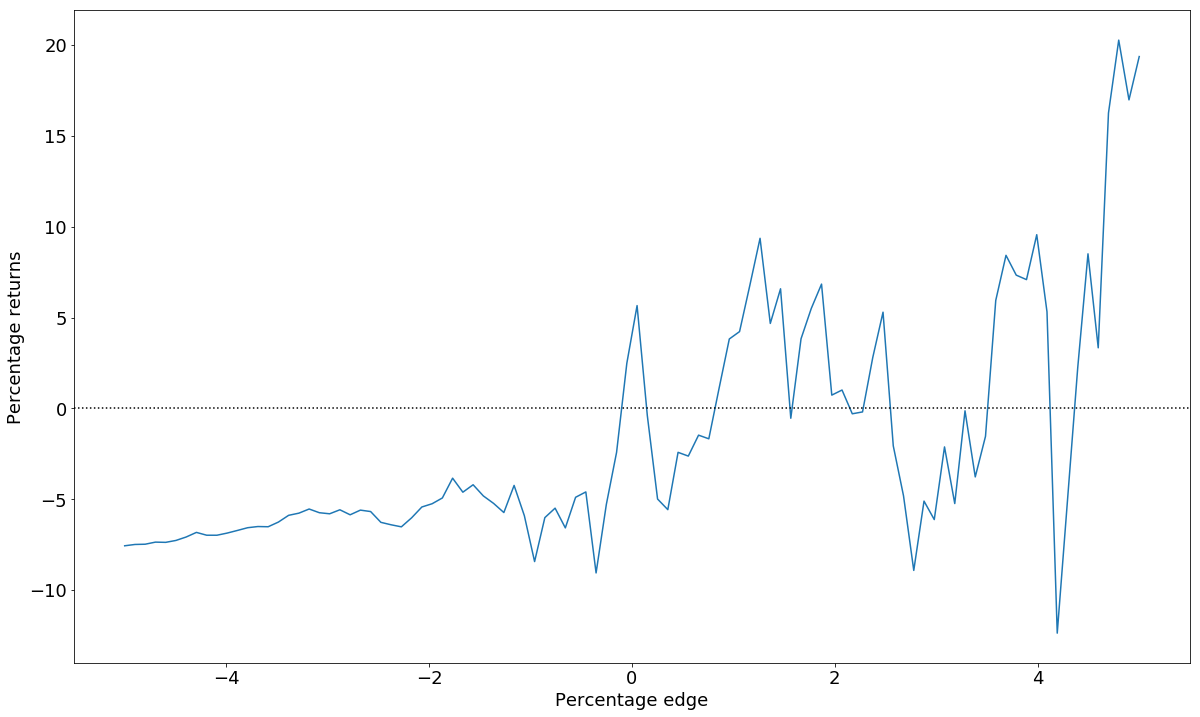

In [291]:
fig, ax = plt.subplots(figsize=(20,12))
plt.plot(t, return_strategy)
ax.axhline(y=0, color='k', ls=':')
plt.xlabel('Percentage edge', fontsize=18)
plt.xticks(fontsize=18)
plt.ylabel('Percentage returns', fontsize=18)
plt.yticks(fontsize=18)
plt.show()

In [297]:
for a, b in zip(t, return_strategy):
    if b > 2.5:
        print(a)

0.050505050505050164
0.9595959595959593
1.0606060606060606
1.1616161616161618
1.262626262626262
1.3636363636363633
1.4646464646464645
1.666666666666667
1.7676767676767673
1.8686868686868685
2.3737373737373737
2.474747474747475
3.5858585858585865
3.686868686868687
3.787878787878787
3.8888888888888893
3.9898989898989896
4.09090909090909
4.494949494949495
4.595959595959595
4.696969696969697
4.797979797979798
4.8989898989899
5.0


In [300]:
float(pct_returns(1.3, merged)) * 100

10.099866844207723

In [307]:
merged[merged.prob_diff >= 1.3][['event_name', 'score_name_x', 'score_name_y', 'back_pct_chance', 'calculated_prob', 'bet_return']].bet_return.sum()

Decimal('151.7')

In [310]:
merged.pct_back_difference.describe()

count    9399.000000
mean       -0.010612
std         1.241499
min        -0.990614
25%        -0.313715
50%        -0.102430
75%         0.136336
max        75.781281
Name: pct_back_difference, dtype: float64

In [312]:
t = np.linspace(-1, 1, 100)
return_strategy = [100.*float(other_pct_returns(l, merged)) for l in t]

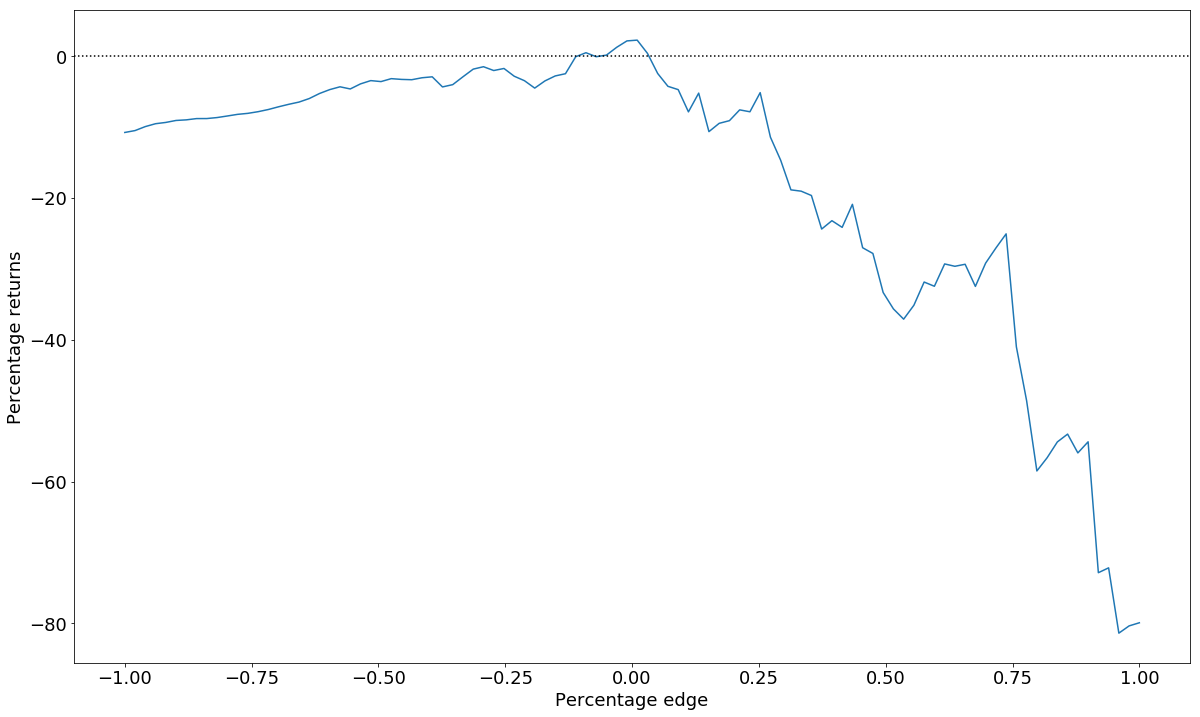

In [313]:
fig, ax = plt.subplots(figsize=(20,12))
plt.plot(t, return_strategy)
ax.axhline(y=0, color='k', ls=':')
plt.xlabel('Percentage edge', fontsize=18)
plt.xticks(fontsize=18)
plt.ylabel('Percentage returns', fontsize=18)
plt.yticks(fontsize=18)
plt.show()

In [320]:
merged[merged.event_name == 'Tottenham v Barcelona'][[
    'event_name', 'score_name_x','back_odds', 'lay_odds', 'lay_ltp', 'back_pct_chance', 'lay_pct_chance', 'calculated_prob', 'score_name_y'
]].head()

,event_name,score_name_x,back_odds,lay_odds,lay_ltp,back_pct_chance,lay_pct_chance,calculated_prob,score_name_y
835,Tottenham v Barcelona,2 - 4,22,23,22.0,4.5454545454545455,4.3478260869565217,4.016004,0 - 0
836,Tottenham v Barcelona,2 - 4,21,22,22.0,4.7619047619047619,4.5454545454545455,9.706689,1 - 0
837,Tottenham v Barcelona,2 - 4,8.2,8.4,8.4,12.1951219512195122,11.9047619047619048,7.778654,1 - 1
838,Tottenham v Barcelona,2 - 4,13,13.5,13.0,7.6923076923076923,7.4074074074074074,3.218307,0 - 1
839,Tottenham v Barcelona,2 - 4,30,32,32.0,3.3333333333333333,3.1250000000000000,11.730542,2 - 0


In [323]:
merged.loc[:, 'lay_prob_diff'] = merged.apply(lambda x: x.calculated_prob - float(x.lay_pct_chance), axis=1)
merged.sort_values(by='lay_prob_diff').head()

,event_name,event_id,open_date,score_name_x,home_team,away_team,home_elo,away_elo,home_team_goal,away_team_goal,...,lay_pct_chance,back_ltp,back_odds,back_vol,back_pct_chance,calculated_prob,prob_diff,bet_return,pct_back_difference,lay_prob_diff
97,Hendon v Lancing FC,28932649,2018-10-02 18:45:00,1 - 1,Hendon,Lancing FC,1054.953229,1000.000000,1.0,1.0,...,97.0873786407766990,1.03,24,2.36,4.1666666666666667,6.526432,2.359765,-1,0.566344,-90.560947
34,Leeds U23 v Nottm Forest U23,28932311,2018-10-01 12:30:00,2 - 0,Leeds U23,Nottm Forest U23,1093.409300,1054.928360,2.0,0.0,...,92.5925925925925926,1.13,1.02,62.1,98.0392156862745098,6.914196,-91.125020,1.02,-0.929475,-85.678397
10,Leeds U23 v Nottm Forest U23,28932311,2018-10-01 12:00:00,2 - 0,Leeds U23,Nottm Forest U23,1093.409300,1054.928360,2.0,0.0,...,92.5925925925925926,1.13,1.02,62.1,98.0392156862745098,6.914196,-91.125020,1.02,-0.929475,-85.678397
4231,Nottm Forest U23 v Birmingham U23,28955493,2018-10-15 13:00:00,0 - 1,Nottm Forest U23,Birmingham U23,1034.896702,987.787993,0.0,1.0,...,91.7431192660550459,1.11,1.03,48.5,97.0873786407766990,8.947037,-88.140341,1.03,-0.907846,-82.796082
4249,Nottm Forest U23 v Birmingham U23,28955493,2018-10-15 18:00:00,0 - 1,Nottm Forest U23,Birmingham U23,1034.896702,987.787993,0.0,1.0,...,91.7431192660550459,1.11,1.03,48.5,97.0873786407766990,8.947037,-88.140341,1.03,-0.907846,-82.796082


In [324]:
merged.sort_values(by='lay_prob_diff', ascending=False).head()

,event_name,event_id,open_date,score_name_x,home_team,away_team,home_elo,away_elo,home_team_goal,away_team_goal,...,lay_pct_chance,back_ltp,back_odds,back_vol,back_pct_chance,calculated_prob,prob_diff,bet_return,pct_back_difference,lay_prob_diff
851,Tottenham v Barcelona,28912395,2018-10-03 19:00:00,2 - 4,Tottenham,Barcelona,1298.170964,1002.081203,2.0,4.0,...,3.3333333333333333,29.0,27,6.66,3.7037037037037037,22.087610,18.383906,-1,4.963655,18.754276
74,Burnley U23 v Crewe U23,28931243,2018-10-01 13:00:00,3 - 2,Burnley U23,Crewe U23,927.885325,983.860275,3.0,2.0,...,0.15384615384615384615,0.0,6.2,9.64,16.1290322580645161,12.100646,-4.028387,-1,-0.249760,11.946800
3791,Leyton Orient v Hartlepool,28938264,2018-10-13 14:00:00,0 - 0,Leyton Orient,Hartlepool,1092.907627,1062.393582,0.0,0.0,...,0.71428571428571428571,30.0,50,1.76,2.0000000000000000,12.647707,10.647707,-1,5.323853,11.933421
5839,The New Saints v Connahs Quay,28959954,2018-10-20 18:30:00,3 - 0,The New Saints,Connahs Quay,1198.352974,1268.174037,3.0,0.0,...,1.6666666666666667,0.0,24,7.72,4.1666666666666667,12.567584,8.400917,-1,2.016220,10.900917
8567,Millwall U23 v Colchester U23,28982082,2018-10-30 13:30:00,2 - 3,Millwall U23,Colchester U23,1057.280917,859.298278,2.0,3.0,...,0.50000000000000000000,0.0,8.6,9.41,11.6279069767441860,11.335076,-0.292830,-1,-0.025183,10.835076


In [325]:
def calculate_return_lay(row, stake=1):
    home_goals = row.home_team_goal
    away_goals = row.away_team_goal
    score_name = row.score_name_y
    try:
        predicted_home_goals = int(score_name.split('-')[0].strip())
        predicted_away_goals = int(score_name.split('-')[1].strip())
        if predicted_home_goals == home_goals and predicted_away_goals == away_goals:
            return -stake * row.lay_odds
        else:
            return stake
    except:
        if home_goals > away_goals and home_goals > 3:
            if score_name == 'Any Other Home Win':
                return -stake * row.lay_odds
        elif away_goals > 3 and away_goals > home_goals:
            if score_name == 'Any Other Away Win':
                return -stake * row.lay_odds
        elif home_goals > 3 and home_goals == away_goals:
            if score_name == 'Any Other Draw':
                return -stake * row.lay_odds
        else:
            return stake
    return stake

In [326]:
merged.loc[:, 'lay_return'] = merged.apply(lambda x: calculate_return_lay(x), axis=1)
merged.sort_values(by='lay_return', ascending=False).head(10)

,event_name,event_id,open_date,score_name_x,home_team,away_team,home_elo,away_elo,home_team_goal,away_team_goal,...,back_ltp,back_odds,back_vol,back_pct_chance,calculated_prob,prob_diff,bet_return,pct_back_difference,lay_prob_diff,lay_return
0,Leeds U23 v Nottm Forest U23,28932311,2018-10-01 12:00:00,2 - 0,Leeds U23,Nottm Forest U23,1093.409300,1054.928360,2.0,0.0,...,12.0,12.5,5.02,8.0000000000000000,7.197587,-0.802413,-1,-0.100302,5.659126,1
6179,MK Dons v Notts Co,28958841,2018-10-23 18:45:00,2 - 1,MK Dons,Notts Co,1045.580415,929.687737,2.0,1.0,...,9.8,9.4,23.49,10.6382978723404255,12.365062,1.726765,-1,0.162316,2.365062,1
6173,Oldham v Cheltenham,28958839,2018-10-23 18:45:00,2 - 0,Oldham,Cheltenham,982.206741,857.978478,2.0,0.0,...,0.0,60,14.23,1.6666666666666667,3.018172,1.351505,-1,0.810903,1.684838,1
6174,Oldham v Cheltenham,28958839,2018-10-23 18:45:00,2 - 0,Oldham,Cheltenham,982.206741,857.978478,2.0,0.0,...,0.0,95,8.93,1.0526315789473684,2.115301,1.062669,-1,1.009536,1.281967,1
6175,Oldham v Cheltenham,28958839,2018-10-23 18:45:00,2 - 0,Oldham,Cheltenham,982.206741,857.978478,2.0,0.0,...,15.5,14,10.32,7.1428571428571429,5.514777,-1.628080,-1,-0.227931,-0.936836,1
6176,Oldham v Cheltenham,28958839,2018-10-23 18:45:00,2 - 0,Oldham,Cheltenham,982.206741,857.978478,2.0,0.0,...,0.0,65,1.93,1.5384615384615385,3.302645,1.764184,-1,1.146719,3.157718,1
6177,MK Dons v Notts Co,28958841,2018-10-23 18:45:00,2 - 1,MK Dons,Notts Co,1045.580415,929.687737,2.0,1.0,...,17.5,17.5,12.12,5.7142857142857143,8.892160,3.177874,-1,0.556128,3.629002,1
6178,MK Dons v Notts Co,28958841,2018-10-23 18:45:00,2 - 1,MK Dons,Notts Co,1045.580415,929.687737,2.0,1.0,...,9.6,9.4,20.49,10.6382978723404255,13.174901,2.536603,-1,0.238441,2.970820,1
6180,MK Dons v Notts Co,28958841,2018-10-23 18:45:00,2 - 1,MK Dons,Notts Co,1045.580415,929.687737,2.0,1.0,...,0.0,21,1,4.7619047619047619,8.345574,3.583669,-1,0.752571,4.178907,1
6171,Oldham v Cheltenham,28958839,2018-10-23 18:45:00,2 - 0,Oldham,Cheltenham,982.206741,857.978478,2.0,0.0,...,110.0,120,1.68,0.83333333333333333333,1.024086,0.190753,-1,0.228903,0.309800,1


In [327]:
merged.sort_values(by='lay_return', ascending=True).head(10)

,event_name,event_id,open_date,score_name_x,home_team,away_team,home_elo,away_elo,home_team_goal,away_team_goal,...,back_ltp,back_odds,back_vol,back_pct_chance,calculated_prob,prob_diff,bet_return,pct_back_difference,lay_prob_diff,lay_return
8972,Concord Rangers v Chelmsford,28973739,2018-10-30 19:45:00,3 - 0,Concord Rangers,Chelmsford,1022.961502,1097.160389,3.0,0.0,...,0.0,60,3.39,1.6666666666666667,2.972346,1.305679,60,0.783408,2.258060,-140
8087,Hartlepool v Sutton Utd,28962528,2018-10-27 14:00:00,2 - 3,Hartlepool,Sutton Utd,1063.795204,1130.329344,2.0,3.0,...,0.0,32,6.5,3.1250000000000000,1.721751,-1.403249,32,-0.449040,0.952520,-130
4471,Fulham U23 v West Brom U23,28961776,2018-10-19 18:00:00,0 - 3,Fulham U23,West Brom U23,955.653811,845.825970,0.0,3.0,...,0.0,55,4.07,1.8181818181818182,1.387244,-0.430938,55,-0.237016,0.553911,-120
2670,Coalville Town v St Neots Town,28945018,2018-10-09 18:45:00,3 - 3,Coalville Town,St Neots Town,1019.574529,932.581222,3.0,3.0,...,0.0,55,3.72,1.8181818181818182,0.804413,-1.013769,55,-0.557573,-0.028920,-120
442,Newport County v Macclesfield,28921141,2018-10-02 18:45:00,3 - 3,Newport County,Macclesfield,1079.620185,963.840599,3.0,3.0,...,100.0,100,2.32,1.00000000000000000000,0.640771,-0.359229,100,-0.359229,-0.192562,-120
538,Aston Villa v Preston,28919933,2018-10-02 18:45:00,3 - 3,Aston Villa,Preston,1092.062107,1045.660160,3.0,3.0,...,110.0,100,7.88,1.00000000000000000000,1.105395,0.105395,100,0.105395,0.196305,-110
1933,Queen of South v Alloa,28925261,2018-10-06 14:00:00,3 - 3,Queen of South,Alloa,1115.899206,1003.082428,3.0,3.0,...,0.0,75,5.29,1.3333333333333333,0.814262,-0.519071,75,-0.389303,-0.094828,-110
1308,Swansea v Ipswich,28921378,2018-10-06 14:00:00,2 - 3,Swansea,Ipswich,1081.768063,994.686548,2.0,3.0,...,95.0,95,1.94,1.0526315789473684,1.211283,0.158651,95,0.150719,0.302192,-110
5917,Charlton U23 v Ipswich U23,28967256,2018-10-22 13:00:00,2 - 2,Charlton U23,Ipswich U23,998.983248,1018.856554,2.0,2.0,...,0.0,8.8,1.96,11.3636363636363636,4.916427,-6.447210,8.8,-0.567354,3.805316,-90
4709,Doncaster v Gillingham,28950965,2018-10-20 14:00:00,3 - 3,Doncaster,Gillingham,1051.766949,954.938534,3.0,3.0,...,80.0,75,2.7,1.3333333333333333,0.649893,-0.683441,75,-0.512581,-0.526578,-85


In [328]:
merged.bet_return.sum()

Decimal('-1009.23')

In [329]:
merged.lay_return.sum()

Decimal('-1133.88')

In [336]:
merged[merged.lay_prob_diff > 2].lay_return.sum()

Decimal('-745.2')

In [339]:
merged[merged.lay_prob_diff < -2].lay_return.sum()

Decimal('167.02')

In [332]:
merged.lay_prob_diff.describe()

count    9399.000000
mean        0.447971
std         3.838739
min       -90.560947
25%        -0.548989
50%         0.306410
75%         1.576986
max        18.754276
Name: lay_prob_diff, dtype: float64

In [346]:
def lay_pct_returns(val, frame):
    return frame[frame.lay_prob_diff < val].lay_return.sum() / frame[frame.prob_diff < val].shape[0]

t = np.linspace(-5, 5, 200)
return_strategy = [100.*float(pct_returns(l, merged)) for l in t]
return_strategy[0]

-7.557054525014053

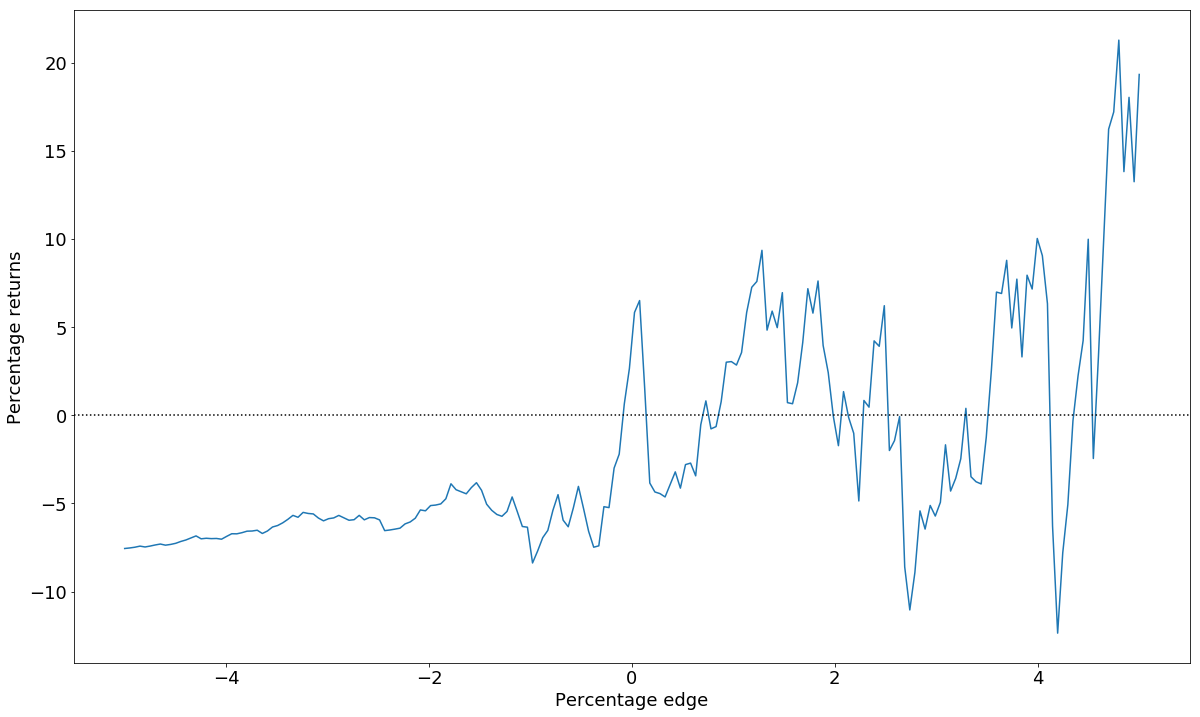

In [347]:
fig, ax = plt.subplots(figsize=(20,12))
plt.plot(t, return_strategy)
ax.axhline(y=0, color='k', ls=':')
plt.xlabel('Percentage edge', fontsize=18)
plt.xticks(fontsize=18)
plt.ylabel('Percentage returns', fontsize=18)
plt.yticks(fontsize=18)
plt.show()

In [348]:
df.head()

,event_name,event_id,open_date,score_name,home_team,away_team,home_elo,away_elo,home_team_goal,away_team_goal,home_attack_elo,home_defence_elo,away_attack_elo,away_defence_elo,expected_home_goals,expected_away_goals
6,Leicester v Chelsea,27425814,2015-04-29 18:45:00,1 - 3,Leicester,Chelsea,1000.0,1000.0,1.0,3.0,1.359675,1.182145,1.182145,1.359675,1.359675,1.182145
93,Nostell Miners Welfare v Frickley Athletic,27434210,2015-05-01 18:30:00,Any Other Away Win,Nostell Miners Welfare,Frickley Athletic,1000.0,1000.0,NaN,NaN,1.359675,1.182145,1.182145,1.359675,1.359675,1.182145
17,Celtic v Dundee,27428357,2015-05-01 18:45:00,5 - 0,Celtic,Dundee,1000.0,1000.0,5.0,0.0,1.359675,1.182145,1.182145,1.359675,1.359675,1.182145
59,Nottm Forest v Cardiff,27428775,2015-05-02 11:15:00,1 - 2,Nottm Forest,Cardiff,1000.0,1000.0,1.0,2.0,1.359675,1.182145,1.182145,1.359675,1.359675,1.182145
58,Norwich v Fulham,27428774,2015-05-02 11:15:00,4 - 2,Norwich,Fulham,1000.0,1000.0,4.0,2.0,1.359675,1.182145,1.182145,1.359675,1.359675,1.182145
